## Collaborative Filter to recommend users based on a seed population

#### As a first pass, I selected 500 users seen on 1/3/2015.  I used impressions served to these users over the course of a week to determine which domains they tend to visit.  This information is used to form the collaborative filter.

#### The Hive query:

#### In the real recommendation engine, we will pull all uuids from a seed population and run a  similar Hive query to identify all domains visited by those users over a particular time frame.          It might look like this:

#### (Note: this only looks at site_id and not the referring url)

#### Then, we would need to pull similar information for a wide variety of users.  It may be useful to create a UDF to do Jaccard similarity in Hive.  For the purposes of this example, I'll just look at similarity amongst users in a single dataset.

#### Now load the table as a dataframe:

In [3]:
import pandas as pd
%pylab inline

#df = pd.read_csv('/path/to/data', sep = '\t', header = None)
#df.columns = ['uuid', 'site_id', 'referingurl', 'count']
#df.head()

Populating the interactive namespace from numpy and matplotlib


#### In order to score each site, first look at the distribution of number of distinct sites per user

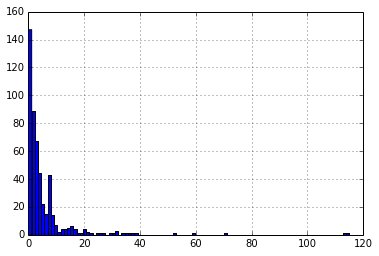

In [19]:
df.groupby(by='uuid')['site_id'].count().hist(bins = 100)

#### There are quite a few users who have been shown ads on 10 or more sites.   As a first pass, we'll count each site equally regardless of the number visited per user.  First I'll walk through the code, then we'll run it on this impression data:

#### Visit_dict makes a dict of sites visited and number of times visited for each uuid.  

In [20]:
def visit_dict(df):
    site_dict = {}
    
    for user in df['uuid'].unique():
        site_dict[user] = df[df['uuid']==user].groupby(by='site_id')['count'].sum().to_dict()
    return site_dict

#### Implementation of Jaccard score (does not account for how many visits were made to each site) :

In [7]:
def Jaccard(site_dict, uuid1, uuid2):
    
    common_items = 0
    
    for item in site_dict[uuid1]:
        if item in site_dict[uuid2]:
            common_items += 1
    
    union = len(site_dict[uuid1]) + len(site_dict[uuid2]) - common_items

    return (common_items/float(union)) if union else 0

#### Jaccard_weighted is an implementation of Jaccard score in which each visit to a site is counted as an individual item

In [22]:
def Jaccard_weighted(site_dict, uuid1, uuid2):
    
    common_items = 0
    
    for item in site_dict[uuid1]:
        if item in site_dict[uuid2]:
            common_items += site_dict[uuid1][item] + site_dict[uuid2][item]
    
    union = sum(site_dict[uuid1].values()) + sum(site_dict[uuid2].values()) - common_items

    return (common_items/float(union)) if union else 0

#### Score_matrix uses the desired metric to construct a co-occurrence matrix.  This matrix is currently symmetric and not triangularized.

In [37]:
def score_matrix(site_dict, type = 'Jaccard'):
    
    score_list = []
    headers = ['uuid1', 'uuid2', 'score']
    
    for user1 in site_dict:
        for user2 in site_dict:
            if user1 != user2:
                score_list.append([user1, user2, Jaccard(site_dict, user1, user2)])
    
    matrix = pd.DataFrame(score_list, columns = headers)
    print len(matrix[matrix['score']==0])
    
    # remove all uuid-to-uuid comparisons with nothing in common
    return matrix[matrix['score']>0]

#### Main function, which takes a dataframe and identifies users with sites in common

In [38]:
def main(df):
    site_dict = visit_dict(df)
    matrix = score_matrix(site_dict).sort(columns = 'score', ascending = False)
    return matrix

#### Now it's time to score the impresson data we loaded above:

In [34]:
matrix = main(df)

#### Take a look at the histogram of non-zero scores 

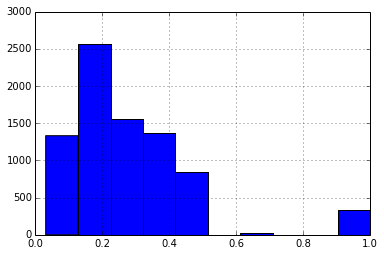

In [35]:
matrix['score'].hist(bins = 10, normed = False)

#### Recall that this matrix is not triangularized, so pairs are double-counted in the histogram.  

### Approximately 3.3% of the possible uuid pairs had site visits in common. (4024 pairs out of 124,000 possible pairs)

In [53]:
#implementation of Pearson correlation score
# Not yet checked for bugs
from math import sqrt

def Pearson(site_dict, uuid1, uuid2):
    common_list = {}
    
    for item in site_dict[uuid1]:
        if item in site_dict[uuid2]:
            common_list[item]=1
            
    n = len(common_list)
    
    if n == 0:
        print "error 1"
        return 0
    
    sum1 = sum([site_dict[uuid1][item] for item in common_list])
    sum2 = sum([site_dict[uuid2][item] for item in common_list])
    print "sum1 is ", sum1, " and sum2 is ", sum2
    print "n is ", n
    
    sum1Sq = sum([pow(site_dict[uuid1][item],2) for item in common_list])
    sum2Sq = sum([pow(site_dict[uuid2][item],2) for item in common_list])
    print "sum1Sq is ", sum1Sq, " and sum2Sq is ", sum2Sq

    pSum = sum([site_dict[uuid1][item]*site_dict[uuid2][item] for item in common_list])
    
    num = pSum - (sum1*sum2/n)
    den = sqrt((sum1Sq - pow(sum1,2)/n)*(sum2Sq - pow(sum2,2)/n))
    if den==0: 
        print "error 2"
        return 0
    
    r = num/den
    
    return r

# Types of collaborative filtering

- Use Matrix Factorization when # users becomes large (> 3000)

